In [2]:
import re, string,os
from glob import glob as gb
import pandas as pd
from collections import Counter
from tqdm import tqdm
from datetime import datetime, timedelta, date
from collections import OrderedDict
import subprocess
from utils.functions import *
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

plotting.style(12)

In [ ]:
### Pointwise Mutual Information for identifying related terms

pmi_data = pd.DataFrame()
list_bins = [[x,x+3] for x in range(1957,1985)]

for c,bin in enumerate(list_bins):
    data = data_loader.subset(data_version="lemmatized_pm",start_date=bin[0],end_date=bin[1],words=[],preprocess=True)
    pmi_df = frequency.get_pmi_table(data,"|".join([str(x) for x in range(bin[0],bin[1])]),12,'bureaucracy',text_column="text_lemmatized")
    pmi_df['period'] = "-".join([str(x) for x in list_bins[c]])
    pmi_data = pmi_data.append(pmi_df)

In [ ]:
d = pd.DataFrame()
for y in sorted(list(set(pmi_data['period']))):
    t = list(pmi_data[pmi_data['period'] == y].sort_values('npmi')['w'][1:50])
    d[y] = t
pmi_data.to_csv('/media/ruben/OSDisk/Users/ruben.ros/Documents/GitHub/CrisisBureaucracy/results/pmi-table-s3-w12-1957-1985.csv',index=False)
d.to_csv('/media/ruben/OSDisk/Users/ruben.ros/Documents/GitHub/CrisisBureaucracy/results/pmi-topwords-s12-w8-1957-1985.csv',index=False)

In [15]:
## Diachronic PMI

def get_pmi_score(word1,word2,year,text_column):
    data_path = "/media/ruben/Elements/PhD/data/hansard/lemmatized_pm"
    p1 = int(subprocess.check_output(f'egrep -iE "{word1}"  {data_path}/*{year}* | wc -l',shell=True).decode('utf-8'))
    p2 = int(subprocess.check_output(f'egrep -iE "{word2}"  {data_path}/*{year}* | wc -l',shell=True).decode('utf-8'))
    p12 = int(subprocess.check_output(f'egrep -iE "{word1}.*{word2}|{word2}.*{word1}"  {data_path}/*{year}* | wc -l',shell=True).decode('utf-8'))
    if p12 > 0:
        try:
            pmi_reg = math.log(((p12) / (p1 * p2)), 2)
            npmi = pmi_reg / - math.log(p12)
            print(year,word2,p1,p2,p12,npmi)
            return npmi
        except:
            return 0

pmi_data = []

terms = ["administrative","control","government","money","brussels","industry","democracy","people","reduce"]
terms = ["administrative","control"]
for term in terms:
    for year in range(1957,1985,3):
        pmi_ = get_pmi_score('bureaucracy',term,year,text_column="text_lemmatized")
        pmi_data.append([term,pmi_,year])

1957 administrative 30 1188 3 12.321223197037641
1966 administrative 71 1042 7 6.869552412897976
1969 administrative 120 780 2 22.382289569186838
1972 administrative 110 865 3 13.61076486178362
1975 administrative 273 905 14 5.345536090680329
1978 administrative 335 738 11 6.0286463870033185
1981 administrative 254 517 2 23.087023370937803
1984 administrative 245 573 8 6.780199868648317
1957 control 30 3666 5 8.962727583224918
1963 control 34 3020 3 13.710781619785886
1966 control 71 3578 7 7.784187711263341
1969 control 120 4909 19 5.067239171570412
1972 control 110 4328 9 7.141245213510159
1975 control 273 4571 30 4.511399641680519
1978 control 335 5169 33 4.484272485415901
1981 control 254 5331 21 5.247640001855233
1984 control 245 6341 25 4.946843953318831


In [16]:
pmi_data = pd.DataFrame(pmi_data,columns=['term','pmi','year']).fillna(0)
pmi_data['pmi'] = pmi_data['pmi'].astype(float)
#pmi_data.to_csv('~/Documents/GitHub/CrisisBureaucracy/results/pmi-dia-selected-words.csv',index=False)

In [17]:
pmi_data = pmi_data.pivot(index='year',columns='term',values='pmi').reset_index()

<AxesSubplot:xlabel='year'>

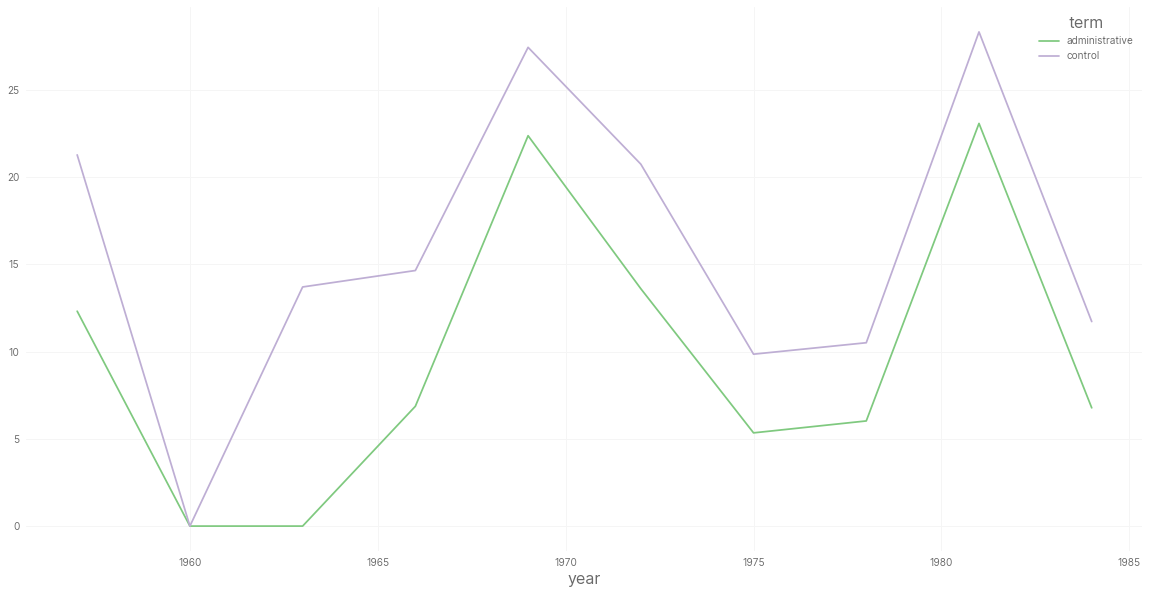

In [18]:
fig, ax = plt.subplots()
pmi_data.plot(x='year',y=list(pmi_data.columns)[1:],figsize=(20,10),stacked=True,ax=plt.gca())
# plt.xlabel("Years (1957—1984)",labelpad=20)
# plt.ylabel("Normalized Frequency / Year",labelpad=20)
# ax.legend(title="Parties",fontsize=16)
# plt.savefig("/media/ruben/OSDisk/Users/ruben.ros/Documents/GitHub/CrisisBureaucracy/results/freq-bureaucracy-rel-bar-party.png",dpi=450)
# plt.show()

In [24]:
pmi_data

term,year,administrative,brussels,control,democracy,government,industry,money,people,reduce
0,1957,13.776387,0.000000,6.325245,12.500715,6.651871,8.856875,0.000000,6.351862,0.000000
1,1958,0.000000,0.000000,7.996359,12.273651,6.158824,8.957466,15.689361,7.412095,0.000000
2,1959,0.000000,0.000000,0.000000,0.000000,6.783468,13.249474,12.421807,7.108941,0.000000
3,1960,22.769167,0.000000,12.610566,0.000000,6.256701,7.202190,12.836836,6.569710,0.000000
4,1961,10.559053,0.000000,10.365451,0.000000,5.700219,7.117469,10.586905,7.667546,0.000000
5,1962,13.410697,13.749196,11.937907,20.585577,5.482436,13.041268,12.202228,6.568556,24.240761
6,1963,0.000000,13.821117,9.230635,9.800495,5.352125,10.033120,26.462722,5.348766,25.055292
7,1964,23.032717,0.000000,9.288358,20.261778,5.916309,13.283006,26.049977,5.614146,11.615830
8,1965,6.427924,17.998679,7.077710,0.000000,4.937684,7.324648,7.980663,5.541214,8.106043
9,1966,5.865272,7.934962,5.530522,13.765097,4.299023,6.031588,6.505821,5.051316,10.662728
